## Ex. 2: Q-Learning for Frozen Lake

- $Q_{(s,a)} \leftarrow Q_{(s,a)} + \alpha \; [R_{t+k+1} + \gamma\; \underset{a'}{max}\; Q_{(s',a')} - Q_{(s,a)}]$
- Environment: SFFF FHFH FFFH HFFG
- Actions: Left = 0, Down = 1, Right = 2, Up = 3

**Implementation**: Agent = class, Q = dict

**Algo.**:
```
1. Init Q for all s, a
2. Init alpha=0.001 gamma=0.9 epsilon range [0.01, 1.0]
3. For n_episodes:
        Init s
        For each step of episode:
            choose a with epsilon-greedy
            perform a, get new state s' and reward r
            Update Q(s,a)
            update to new state
            s = s'
            
```

In [20]:
import random
import gym
import numpy as np
import matplotlib.pyplot as plt

In [36]:
# Actions: Left = 0, Down = 1, Right = 2, Up = 3
Actions = [0, 1, 2, 3]
N_STATES = 16
N_ACTIONS = len(Actions)
N_EPISODES = 800000

#### Agent

In [37]:
class Agent:
    def __init__(self, alpha=0.001, gamma=0.90, n_actions=4, n_states=2, 
                 eps_start=1.0, eps_end=0.1, eps_dec=0.005):
        self.alpha = alpha
        self.gamma = gamma
        self.n_actions = n_actions
        self.n_states = n_states
        self.epsilon = eps_start
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        
        self.Q = {}
        self.init_Q()
        
    def init_Q(self):
        for p in range(self.n_states):
            for q in range(self.n_actions):
                self.Q[(p,q)] = 0.0
                
    def decide_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(0, self.n_actions)
        else:
            # Find the Q values for the given state 
            Q_values = np.array([self.Q[(state, a)] for a in range(self.n_actions)])
            
            # Find the position of the max. Q value
            index_Q_max = np.argmax(Q_values)
            
            # Due to our indexing method - our action value is the index itself!
            action = index_Q_max
        return action
    
    # Decrease episilon geometrically
    def decrement_epsilon(self):
        self.epsilon = self.epsilon*self.eps_dec if self.epsilon>self.eps_min\
                       else self.eps_min
    
    # Bellman equation
    def learn(self, state, action, reward, next_state):
        
        ### Step 1: For the NEXT state, find action with max Q
        
        # Find the Q values for the NEXT state 
        next_state_Q_values = np.array([self.Q[(next_state, a)] for a in range(self.n_actions)])
        
        # Find the position of the max. Q value
        index_Q_max = np.argmax(next_state_Q_values)
        
        # Actions: Left = 0, Down = 1, Right = 2, Up = 3
        # Index represents the action it-self, so index=0 is left, similarly index=2 implies go-right
        # Due to our indexing method - our action value is the index itself!
        action_max = index_Q_max

        ### Step 2: Apply B.E.
        self.Q[(state, action)] += self.alpha*(reward +
                                        self.gamma*self.Q[(next_state, action_max)] -
                                        self.Q[(state, action)])
        self.decrement_epsilon()

In [38]:
env = gym.make('FrozenLake-v1')

In [39]:
n_plot_steps = 100
n_print_steps = 50000
average_scores = []
scores = []

agent = Agent(alpha=0.001, gamma=0.9, eps_start=1.0, eps_end=0.01, eps_dec=0.9999995, 
              n_actions=N_ACTIONS, n_states=N_STATES)

for n in range(N_EPISODES):
    done = False
    score = 0

    # Begin episode, each step is a time-step
    state = env.reset()
    while not done:
        action = agent.decide_action(state)
        # Perform suggested action, and get new reward and new state 
        #   say it moved from state x, by doing a left to state z
        next_state, reward, done, info = env.step(action)
        
        # Learn: Update Q value
        agent.learn(state, action, reward, next_state)
        # Increment scores
        score += reward
        
        # Update state
        state = next_state
    
    # Episode terminated
    scores.append(score)
                
    # print average every 10 records
    if n % n_plot_steps == 0:
        average = np.mean(scores[-n_plot_steps:])
        average_scores.append(average)
        if n % n_print_steps == 0:
            print('episode ', n, 'win pct %.2f' % average, 'epsilon %.2f' % agent.epsilon)

episode  0 win pct 0.00 epsilon 1.00
episode  50000 win pct 0.02 epsilon 0.82
episode  100000 win pct 0.03 epsilon 0.66
episode  150000 win pct 0.05 epsilon 0.50
episode  200000 win pct 0.13 epsilon 0.35
episode  250000 win pct 0.27 epsilon 0.22
episode  300000 win pct 0.43 epsilon 0.13
episode  350000 win pct 0.52 epsilon 0.06
episode  400000 win pct 0.62 epsilon 0.02
episode  450000 win pct 0.66 epsilon 0.01
episode  500000 win pct 0.64 epsilon 0.01
episode  550000 win pct 0.74 epsilon 0.01
episode  600000 win pct 0.67 epsilon 0.01
episode  650000 win pct 0.72 epsilon 0.01
episode  700000 win pct 0.67 epsilon 0.01
episode  750000 win pct 0.64 epsilon 0.01


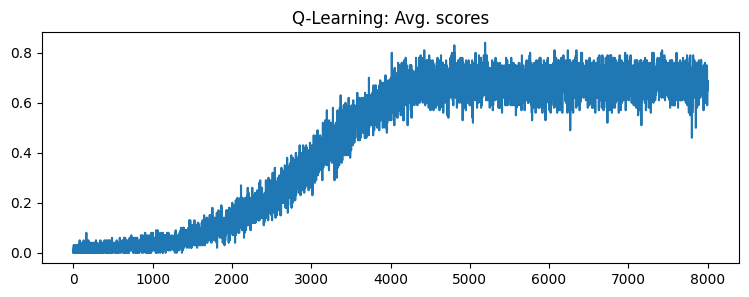

In [40]:
plt.figure(figsize=(9,3))
plt.plot(average_scores)
plt.title('Q-Learning: Avg. scores')
plt.show()

In [34]:
# Actions: Left = 0, Down = 1, Right = 2, Up = 3 
# Rewards: Reach goal(G): +1, Reach hole(H): 0, Reach frozen(F): 0
# Environment
# S F F F 
# F H*F*H 
# F F=F=H
# H F+F+G

# * 500K episodes
# 500K episodes: State 6 *F*
# (6, 0) l: 0.106, Hole
# (6, 1) D: 0.093, BEST. Correct but low
# (6, 2) R: 0.112, Hole
# (6, 3) U: 0.023,

# 500K episodes: State 10 =F=
# (10, 0) L: 0.305, Correct
# (10, 1) D: 0.259, BEST. Correct but low
# (10, 2) R: 0.224, Hole
# (10, 3) U: 0.105, Ok
# 800K episodes: State 10 =F=
(10, 0): 0.305,
 (10, 1): 0.27,
 (10, 2): 0.236,
 (10, 3): 0.109,

# 500K episodes: State 14 +F+
# (14, 0) l: 0.402, 
# (14, 1) D: 0.627, ?? Highest but falling off the ice
# (14, 2) R: 0.602, BEST! = Goal. Lower than D?
# (14, 3) U: 0.540, Ok
# 800K episodes: State 14 +F+
# (14, 0): 0.399,
# (14, 1): 0.639,
# (14, 2): 0.611,
# (14, 3): 0.538,


In [41]:
Qf=agent.Q.copy()
for k, v in Qf.items():
    Qf[k] = round(v,3)
Qf

{(0, 0): 0.07,
 (0, 1): 0.065,
 (0, 2): 0.066,
 (0, 3): 0.06,
 (1, 0): 0.039,
 (1, 1): 0.043,
 (1, 2): 0.041,
 (1, 3): 0.061,
 (2, 0): 0.076,
 (2, 1): 0.068,
 (2, 2): 0.072,
 (2, 3): 0.057,
 (3, 0): 0.029,
 (3, 1): 0.029,
 (3, 2): 0.025,
 (3, 3): 0.055,
 (4, 0): 0.093,
 (4, 1): 0.071,
 (4, 2): 0.064,
 (4, 3): 0.049,
 (5, 0): 0.0,
 (5, 1): 0.0,
 (5, 2): 0.0,
 (5, 3): 0.0,
 (6, 0): 0.114,
 (6, 1): 0.09,
 (6, 2): 0.106,
 (6, 3): 0.022,
 (7, 0): 0.0,
 (7, 1): 0.0,
 (7, 2): 0.0,
 (7, 3): 0.0,
 (8, 0): 0.072,
 (8, 1): 0.116,
 (8, 2): 0.102,
 (8, 3): 0.148,
 (9, 0): 0.163,
 (9, 1): 0.25,
 (9, 2): 0.203,
 (9, 3): 0.136,
 (10, 0): 0.305,
 (10, 1): 0.27,
 (10, 2): 0.236,
 (10, 3): 0.109,
 (11, 0): 0.0,
 (11, 1): 0.0,
 (11, 2): 0.0,
 (11, 3): 0.0,
 (12, 0): 0.0,
 (12, 1): 0.0,
 (12, 2): 0.0,
 (12, 3): 0.0,
 (13, 0): 0.187,
 (13, 1): 0.318,
 (13, 2): 0.389,
 (13, 3): 0.264,
 (14, 0): 0.399,
 (14, 1): 0.639,
 (14, 2): 0.611,
 (14, 3): 0.538,
 (15, 0): 0.0,
 (15, 1): 0.0,
 (15, 2): 0.0,
 (15, 3): 0.

In [35]:
Qf=agent.Q.copy()
for k, v in Qf.items():
    Qf[k] = round(v,3)
Qf

{(0, 0): 0.068,
 (0, 1): 0.066,
 (0, 2): 0.066,
 (0, 3): 0.06,
 (1, 0): 0.039,
 (1, 1): 0.042,
 (1, 2): 0.041,
 (1, 3): 0.061,
 (2, 0): 0.074,
 (2, 1): 0.062,
 (2, 2): 0.066,
 (2, 3): 0.05,
 (3, 0): 0.032,
 (3, 1): 0.021,
 (3, 2): 0.013,
 (3, 3): 0.028,
 (4, 0): 0.091,
 (4, 1): 0.072,
 (4, 2): 0.064,
 (4, 3): 0.048,
 (5, 0): 0.0,
 (5, 1): 0.0,
 (5, 2): 0.0,
 (5, 3): 0.0,
 (6, 0): 0.106,
 (6, 1): 0.093,
 (6, 2): 0.112,
 (6, 3): 0.023,
 (7, 0): 0.0,
 (7, 1): 0.0,
 (7, 2): 0.0,
 (7, 3): 0.0,
 (8, 0): 0.072,
 (8, 1): 0.117,
 (8, 2): 0.101,
 (8, 3): 0.142,
 (9, 0): 0.157,
 (9, 1): 0.248,
 (9, 2): 0.207,
 (9, 3): 0.133,
 (10, 0): 0.305,
 (10, 1): 0.259,
 (10, 2): 0.224,
 (10, 3): 0.105,
 (11, 0): 0.0,
 (11, 1): 0.0,
 (11, 2): 0.0,
 (11, 3): 0.0,
 (12, 0): 0.0,
 (12, 1): 0.0,
 (12, 2): 0.0,
 (12, 3): 0.0,
 (13, 0): 0.19,
 (13, 1): 0.308,
 (13, 2): 0.372,
 (13, 3): 0.264,
 (14, 0): 0.402,
 (14, 1): 0.627,
 (14, 2): 0.602,
 (14, 3): 0.54,
 (15, 0): 0.0,
 (15, 1): 0.0,
 (15, 2): 0.0,
 (15, 3): 0

#### Ex.1 plot: Deterministic Policy: Avg. score, per 10 episodes

In [27]:
#plt.figure(figsize=(9,3))
#plt.plot(average_scores)
#plt.title('Deterministic Policy: Avg. score, per 10 episodes')
#plt.show()